# Bag of Words and Tf-Idf
## Part 2 of the Workshop "Text Classification - From Zero to Hero", by Dr. Omri Allouche, Gong.io, Bar Ilan University
In this notebook, we perform a very basic EDA (Exploratory Data Analysis) of the dataset, and build a basic classifier using Tf-Idf encoding.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams["axes.labelsize"] = 15

In [2]:
df = pd.read_csv('data/20newsgroups.csv')
df.head()

,original_text,target,label,text,num_chars
0,"\n\nAs far as I know, Toronto, Pittsburgh, and...",0,rec.sport.baseball,"as far as i know , toronto , pittsburgh , and ...",538
1,Dunno about Miller.\n\nIf you mean Scott Erick...,0,rec.sport.baseball,dunno about miller . if you mean scott erickso...,274
2,I am planning a weekend in Chicago next month ...,0,rec.sport.baseball,i am planning a weekend in chicago next month ...,267
3,i think lamont is tryin sax out in left becaus...,0,rec.sport.baseball,i think lamont is tryin sax out in left becaus...,291
4,I'm looking for software (hopefully free and r...,0,rec.sport.baseball,i'm looking for software (hopefully free and r...,225


In [3]:
df['label'].value_counts()

rec.sport.hockey         229
rec.sport.baseball       229
talk.politics.guns       229
talk.politics.mideast    229
Name: label, dtype: int64

(0, 500)

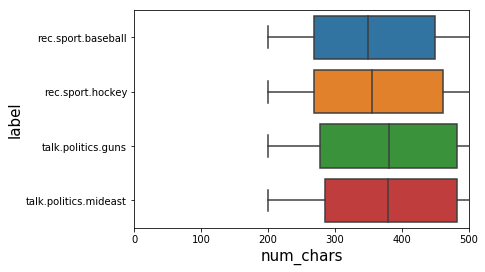

In [4]:
sns.boxplot(data=df, y='label', x='num_chars')
plt.xlim(0,500)

Now let's fit a Tf-Idf vectorizer to these documents. We'll remove English stopwords, and check the words that have the highest Tfidf score for each class:

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

df_train = pd.read_csv('data/train.csv')
vectors = vectorizer.fit_transform(df_train['text'])
vectors.shape

(641, 6579)

In [6]:
df_train['tfidf'] = list(vectors.toarray())

In [7]:
inverse_vocab = {v: k for k,v in vectorizer.vocabulary_.items()}
top_terms = df_train.groupby('label')['tfidf'].apply(lambda x: x.sum(axis=0))
for i,r in top_terms.iteritems():
    print(i)
    print([inverse_vocab[x] for x in np.argsort(r)[-20:][::-1]])
    print()

rec.sport.baseball
['year', 'baseball', 'think', 'team', 'games', 'runs', 'list', 'know', 'hit', 'just', 'don', 'does', 'batting', 'player', 'good', 'game', 'league', 'like', 'win', 'did']

rec.sport.hockey
['game', 'hockey', 'team', 'play', 'espn', 'games', 'don', 'know', 'leafs', 'players', 'win', 'detroit', 'hawks', 'rangers', 'good', 'wings', 'player', 'toronto', 'roger', 'cup']

talk.politics.guns
['fbi', 'people', 'gun', 'just', 'don', 'government', 'like', 'weapons', 'know', 'com', 'guns', 'children', 'texas', 'gas', 'time', 'waco', 'law', 'did', 'use', 'make']

talk.politics.mideast
['israel', 'jews', 'adam', 'people', 'just', 'don', 'israeli', 'like', 'say', 'arab', 'arabs', 'does', 'muslims', 'jewish', 'zionism', 'way', 'edu', '000', 'think', 'war']



### Basic Classifier
Next, let's build a basic classifier. Let's use the Multinomial Naive Bayes.

We'll first fit the model on the train set:

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# We use the vectorizer we fitted earlier to transform the textual string into 
vectors = vectorizer.transform(df_train['text'])
clf = MultinomialNB()
clf.fit(vectors, df_train['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

And then predict and evaluate performance on the validation set:

In [9]:
df.label.value_counts()

rec.sport.hockey         229
rec.sport.baseball       229
talk.politics.guns       229
talk.politics.mideast    229
Name: label, dtype: int64

In [10]:
df_val = pd.read_csv('data/val.csv')
y_truth = df_val['label']
vectors_val = vectorizer.transform(df_val['text'])
y_predict_proba = clf.predict_proba(vectors_val)
y_predict = clf.predict(vectors_val)

In [11]:
metrics.f1_score(y_truth, y_predict, average='macro')

0.8273736214034721

We see that even a simple model performs pretty well. Let's examine the most important features for each class:

In [12]:
def show_top_terms(classifier, vectorizer):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i in range(len(classifier.classes_)):
        top_terms = np.argsort(classifier.coef_[i])[-20:]
        print(classifier.classes_[i])
        print(", ".join(feature_names[top_terms]))
        print()

show_top_terms(clf, vectorizer)

rec.sport.baseball
did, win, like, league, game, good, player, batting, does, don, just, hit, know, list, runs, games, team, think, baseball, year

rec.sport.hockey
cup, roger, toronto, player, wings, good, rangers, hawks, detroit, win, players, leafs, know, don, games, espn, play, team, hockey, game

talk.politics.guns
make, use, did, law, waco, time, gas, texas, children, guns, com, know, weapons, like, government, don, just, gun, people, fbi

talk.politics.mideast
war, think, 000, edu, way, zionism, jewish, muslims, does, arabs, arab, say, like, israeli, don, just, people, adam, jews, israel



Let's further examine the classification report and the confusion matrix:

In [13]:
from model_evaluation_utils import *

In [14]:
from sklearn import metrics
print(metrics.classification_report(y_truth, y_predict))

                       precision    recall  f1-score   support

   rec.sport.baseball       0.91      0.70      0.79        44
     rec.sport.hockey       0.81      0.94      0.87        31
   talk.politics.guns       0.71      0.96      0.82        28
talk.politics.mideast       0.90      0.77      0.83        35

            micro avg       0.83      0.83      0.83       138
            macro avg       0.83      0.84      0.83       138
         weighted avg       0.84      0.83      0.82       138



Normalized confusion matrix
[[0.70454545 0.15909091 0.09090909 0.04545455]
 [0.03225806 0.93548387 0.         0.03225806]
 [0.03571429 0.         0.96428571 0.        ]
 [0.02857143 0.         0.2        0.77142857]]


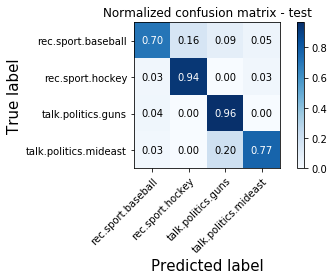

In [15]:
plot_confusion_matrix(y_truth, y_predict, normalize=True, title='Normalized confusion matrix - test');

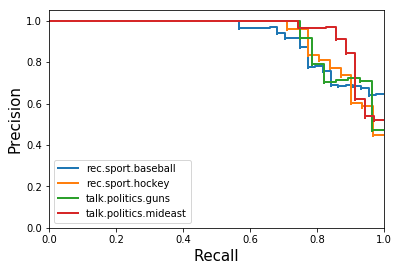

In [16]:
plot_precision_recall_curve(y_predict_proba, y_truth);

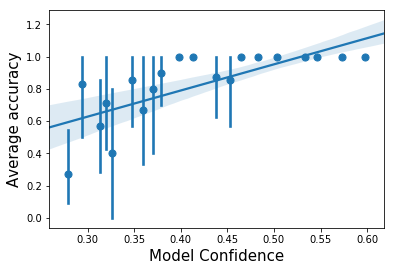

In [17]:
plot_confidence_performance(y_predict, y_predict_proba, y_truth, num_bins=20);

Next, let's perform an error analysis and manually review documents that are wrongly classified. We will focus on documents that have a high model confidence:

In [19]:
df_test = pd.read_csv('data/val.csv')
y_truth = df_test['label']
vectors_val = vectorizer.transform(df_val['text'])
y_predict_proba = clf.predict_proba(vectors_val)
y_predict = clf.predict(vectors_val)

In [20]:
df_test['y_predict'] = clf.predict(vectors_val)
df_test['y_predict_proba'] = np.max(clf.predict_proba(vectors_val))
df_test['is_error'] = (y_predict != y_truth).astype(int)

In [21]:
# df_test['doc_len'] = df_test['text'].str.len()

In [22]:
df_test.sort_values('is_error', ascending=False).head()

,original_text,target,label,text,num_chars,y_predict,y_predict_proba,is_error
137,Giant's have a five man rotation of John Burk...,0,rec.sport.baseball,giant's have a five man rotation of john burke...,202,talk.politics.guns,0.678657,1
13,The Royals are darkness. They are the void of...,0,rec.sport.baseball,the royals are darkness . they are the void of...,293,rec.sport.hockey,0.678657,1
27,\n\nThe tribe will be in town from April 16 to...,0,rec.sport.baseball,the tribe will be in town from april 16 to the...,316,rec.sport.hockey,0.678657,1
26,"\n\tRecently, I heard the Red Sox on WROL a Sp...",0,rec.sport.baseball,"recently , i heard the red sox on wrol a spani...",378,rec.sport.hockey,0.678657,1
24,Which works fine until you end up in the hospi...,2,talk.politics.guns,which works fine until you end up in the hospi...,373,rec.sport.baseball,0.678657,1


In [23]:
def print_document(r):    
    print('Document #{}. True label: {}. Predicted: {} (confidence: {:.1%})'.format(
        r.name,
        r['label'], 
        r['y_predict'],
        r['y_predict_proba']
    ))
    print()
    print(r['text'])

In [25]:
print_document(df_test.iloc[0])

Document #0. True label: rec.sport.hockey. Predicted: rec.sport.hockey (confidence: 67.9%)

in the game *i* have seen yesterday in the olympiahalle of munich canada won 4-1 against sweden! the last goal for canada was at 19:59 in the 3rd period . maybe you shouldn't go and get you another beer before the game is over and then post imaginary results . . . holger


(0, 3000)

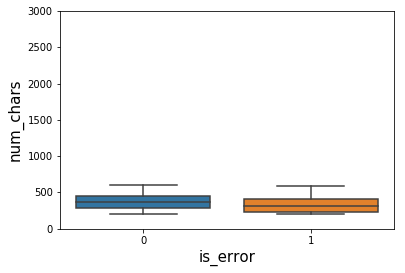

In [26]:
sns.boxplot(data=df_test, x='is_error', y='num_chars')
plt.ylim(0,3000)

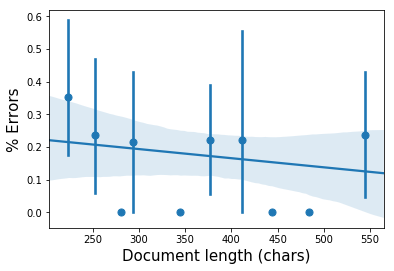

In [27]:
ax = sns.regplot(data=df_test, x='num_chars', y=df_test['is_error'], x_bins=10)
plt.xlabel('Document length (chars)');
plt.ylabel('% Errors');